In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2021-07-18 20:06:55.819502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2021-07-18 20:06:55.819535: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


2.5.0


In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Layer, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [3]:
warnings.filterwarnings('ignore')
dataset = tf.keras.preprocessing.image_dataset_from_directory('../dataset/sharma_59_nih_dataset/Image_dataset', image_size=(224, 224))
dataset

Found 11452 files belonging to 2 classes.


2021-07-18 20:07:04.079345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-18 20:07:08.055395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-07-18 20:07:08.057925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-07-18 20:07:08.060443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:07:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
test_dataset = dataset.take(75)
train_dataset = dataset.skip(75)

valid_dataset = test_dataset.take(25)
test_dataset = test_dataset.skip(25)

# test ~ 1600   valid ~ 800

In [6]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
model1 = load_model('nih_models/mobilenetv2.h5', custom_objects = {'KerasLayer': hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")})


In [5]:
class IdentityBlock(Layer):
    def __init__(self, **kwargs):
        super(IdentityBlock, self).__init__(**kwargs)

    def build(self, input_shape): 
        self.conv1 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='same')
        self.conv2 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='same')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.act = Activation('relu')
        self.add = Add()

    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.add([x, inputs])
        x = self.act(x)
        return x

In [6]:
test_model = Sequential([IdentityBlock(input_shape = (16, 28, 28,3))])
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
identity_block (IdentityBloc (None, 16, 28, 28, 3)     192       
Total params: 192
Trainable params: 180
Non-trainable params: 12
_________________________________________________________________


In [7]:
class Resnet(Model):
    def __init__(self):
        
        super(Resnet, self).__init__()
        self.ida1 = IdentityBlock()
        self.ida2 = IdentityBlock()
        self.conv1 = Conv2D(16, kernel_size=(7,7))
        
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.max_pool = MaxPooling2D(pool_size=(3,3))
        self.global_pool = GlobalAveragePooling2D()
        self.dense2 = Dense(1, activation = 'sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)
        x = self.ida1(x)
        x = self.ida2(x)
        x = self.global_pool(x)
        x = self.dense2(x)
        return x

In [8]:
model = Resnet()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      elif epoch % 5 ==0:
        return lr * tf.math.exp(-0.1)
      else:
        return lr

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_accuracy', restore_best_weights=True)
his = model.fit(train_dataset, validation_data=valid_dataset, epochs = 100, verbose = 1, callbacks = [lrs, early_stop])

Epoch 1/100


2021-07-10 14:41:45.844231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-10 14:41:45.868473: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199895000 Hz


283/283 [==============================] - 323s 1s/step - loss: 0.6883 - accuracy: 0.5523 - val_loss: 0.7744 - val_accuracy: 0.5038
Epoch 2/100
283/283 [==============================] - 383s 1s/step - loss: 0.6819 - accuracy: 0.5612 - val_loss: 2.1242 - val_accuracy: 0.4988
Epoch 3/100
283/283 [==============================] - 386s 1s/step - loss: 0.6785 - accuracy: 0.5728 - val_loss: 0.7097 - val_accuracy: 0.5125
Epoch 4/100
283/283 [==============================] - 385s 1s/step - loss: 0.6741 - accuracy: 0.5802 - val_loss: 0.6844 - val_accuracy: 0.5362
Epoch 5/100
283/283 [==============================] - 385s 1s/step - loss: 0.6723 - accuracy: 0.5846 - val_loss: 1.2081 - val_accuracy: 0.5050
Epoch 6/100
283/283 [==============================] - 356s 1s/step - loss: 0.6703 - accuracy: 0.5859 - val_loss: 0.8518 - val_accuracy: 0.5500
Epoch 7/100
283/283 [==============================] - 269s 948ms/step - loss: 0.6668 - accuracy: 0.5952 - val_loss: 2.5893 - val_accuracy: 0.4837
E

In [9]:
model.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
identity_block_1 (IdentityBl multiple                  4768      
_________________________________________________________________
identity_block_2 (IdentityBl multiple                  4768      
_________________________________________________________________
conv2d (Conv2D)              multiple                  2368      
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0    

In [10]:
loss, acc = model.evaluate(test_dataset)
acc

50/50 [==============================] - 5s 93ms/step - loss: 0.7319 - accuracy: 0.5412


0.5412499904632568

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3fb605ce18>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


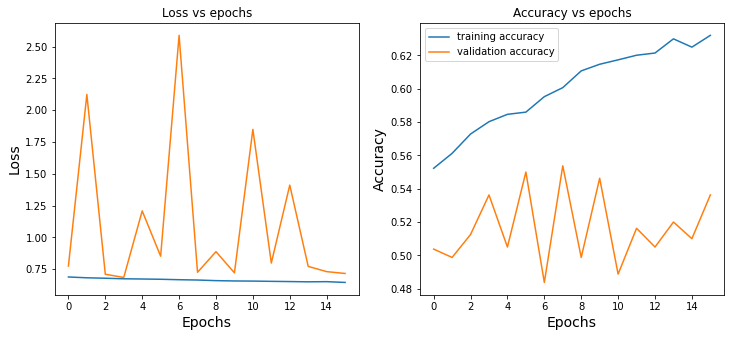

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

In [5]:
from tensorflow.keras import layers
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1)
])

In [6]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    rescale,
    data_augmentation,
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                   trainable=True),
    Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', restore_best_weights=True)
his = model.fit(train_dataset, validation_data=valid_dataset, epochs = 30, callbacks = [early_stop])

Epoch 1/30


2021-07-18 20:08:01.993440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-18 20:08:02.252467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199895000 Hz


283/283 [==============================] - 239s 821ms/step - loss: 0.7360 - accuracy: 0.6469 - val_loss: 0.9072 - val_accuracy: 0.5850
Epoch 2/30
283/283 [==============================] - 252s 888ms/step - loss: 0.7249 - accuracy: 0.6616 - val_loss: 0.7614 - val_accuracy: 0.6137
Epoch 3/30
283/283 [==============================] - 332s 1s/step - loss: 0.7091 - accuracy: 0.6667 - val_loss: 0.8150 - val_accuracy: 0.6250
Epoch 4/30
283/283 [==============================] - 332s 1s/step - loss: 0.6950 - accuracy: 0.6801 - val_loss: 0.7221 - val_accuracy: 0.6762
Epoch 5/30
283/283 [==============================] - 331s 1s/step - loss: 0.6817 - accuracy: 0.6858 - val_loss: 0.7002 - val_accuracy: 0.6700
Epoch 6/30
283/283 [==============================] - 342s 1s/step - loss: 0.6731 - accuracy: 0.6949 - val_loss: 0.7353 - val_accuracy: 0.6438
Epoch 7/30
283/283 [==============================] - 223s 785ms/step - loss: 0.6742 - accuracy: 0.6943 - val_loss: 0.7345 - val_accuracy: 0.6300
E

In [8]:
loss, acc = model.evaluate(test_dataset)
acc

50/50 [==============================] - 5s 90ms/step - loss: 0.6843 - accuracy: 0.6919


0.6918749809265137

In [9]:
loss, val_acc = model.evaluate(valid_dataset)
val_acc

25/25 [==============================] - 2s 91ms/step - loss: 0.7014 - accuracy: 0.6837


0.6837499737739563

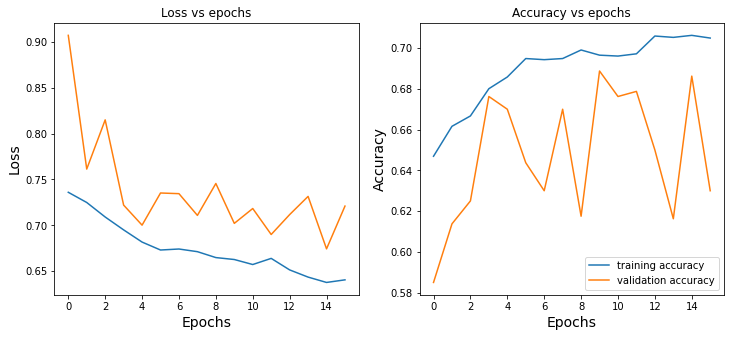

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

In [11]:
labels = []
images = []
for i in test_dataset:
    a,b = i
    labels += list(b.numpy())
    images += list(a.numpy())
len(labels)

1600

In [15]:
prediction = model.predict(np.array(images))
prediction

array([[0.26913   ],
       [0.36935252],
       [0.43918556],
       ...,
       [0.4463295 ],
       [0.725187  ],
       [0.74565816]], dtype=float32)

In [16]:
pred = [i[0] for i in prediction]
len(pred)

1600

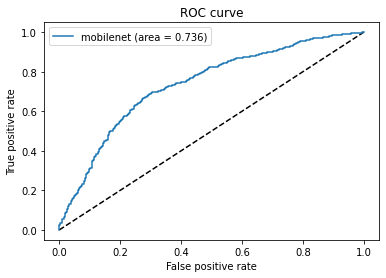

In [17]:
from sklearn import metrics
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(labels, pred)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='mobilenet (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
model.save('nih_models/mobilenetv2.h5')

In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('nih_models/mobilenetv2.h5', custom_objects = {'KerasLayer': hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")})


In [31]:
model1.evaluate(test_dataset)

50/50 [==============================] - 5s 91ms/step - loss: 0.6613 - accuracy: 0.7031


[0.661299467086792, 0.703125]

In [30]:
model1.evaluate(valid_dataset)

25/25 [==============================] - 2s 90ms/step - loss: 0.6903 - accuracy: 0.6750


[0.6903315186500549, 0.675000011920929]